In [457]:

if __name__ == '__main__':
    %run MoleculeGenerator2.ipynb
#    %run Discrim.ipynb
 #   %run ChemEnv.ipynb
    %run MolUtils.ipynb
    #%run Tests.ipynb

    
from torch.utils.tensorboard import SummaryWriter
from time import time
from torch.optim import Adam
import os
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [669]:
class GraphDataLoader():
    def __init__(self,path,batch_size, length):
        self.path = path
        self.length = length
        
        self.batch_size = batch_size
        self.indicies = list(range(length))
        random.shuffle(self.indicies)
        
        self.curr_idx = 0
        
    def __get_exs(self,indices):
        graphs, graph_dict = dgl.load_graphs(self.path, indices)
        last_action = torch.stack([graph_dict['last_action'][idx] for idx in indices],dim = 0)
        last_atom_feat = torch.stack([graph_dict['last_atom_feats'][idx] for idx in indices], dim = 0)
        action = torch.stack([graph_dict['actions'][idx] for idx in indices], dim = 0)
        graphs = dgl.batch(graphs)
        return graphs.to(device), torch.unsqueeze(last_action,dim=1).to(device), last_atom_feat.to(device), action.to(device)
    
    def __next__(self):
        if self.curr_idx + self.batch_size > self.length:
            self.curr_idx = 0 
            random.shuffle(self.indicies)       
        batch_indices = self.indicies[self.curr_idx: self.curr_idx+self.batch_size]
        self.curr_idx += self.batch_size
    
        return self.__get_exs(batch_indices)
        
    
        

In [655]:



# import matplotlib.pyplot as plt
# import numpy as np

In [653]:
# graphs, graph_dict = dgl.load_graphs('./graph_decomp/full_chunka', [i for i in range(5000)])

In [667]:
# l = [int(i) for i in (graph_dict['actions'].tolist())]

4


(array([6.38860e+04, 1.19678e+05, 5.09700e+04, 2.64000e+03, 3.31200e+03,
        3.76000e+02, 2.36000e+02, 1.71000e+02, 2.60000e+01, 8.69100e+03,
        2.15600e+03, 8.38870e+04, 0.00000e+00, 7.39310e+04, 3.01890e+04,
        0.00000e+00, 2.02570e+04, 1.55790e+04, 1.14210e+04, 0.00000e+00,
        7.91300e+03, 4.85900e+03, 0.00000e+00, 3.57900e+03, 2.14100e+03,
        1.12200e+03, 0.00000e+00, 4.82000e+02, 2.50000e+01, 2.00000e+00]),
 array([ 0.        ,  1.43333333,  2.86666667,  4.3       ,  5.73333333,
         7.16666667,  8.6       , 10.03333333, 11.46666667, 12.9       ,
        14.33333333, 15.76666667, 17.2       , 18.63333333, 20.06666667,
        21.5       , 22.93333333, 24.36666667, 25.8       , 27.23333333,
        28.66666667, 30.1       , 31.53333333, 32.96666667, 34.4       ,
        35.83333333, 37.26666667, 38.7       , 40.13333333, 41.56666667,
        43.        ]),
 <BarContainer object of 30 artists>)

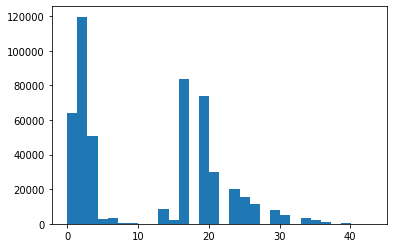

In [668]:
# print(4)
# plt.hist(l, bins=30)

In [649]:
class SupervisedTrainingWrapper():
    def __init__(self, input_dim, batch_size, num_atom_types, writer, data_set_size, path = './graph_decomp/full_chunka'):
        #svt = SupervisedTrainingWrapper(54,5,15,None)
        self.path = path        
        self.policy = BaseLine(input_dim,300,17+1).cuda()
        self.optim = Adam(self.policy.parameters(), lr=3e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.chunk_idx = 0
        
        self.writer = writer
        self.n_iter = 0
        self.cv_iter = 0
        
        self.batch_size = batch_size
        self.data_set_size = data_set_size
        self.dataIter = GraphDataLoader(path,batch_size,data_set_size)
        print(data_set_size)

    def CalcAccuracy(self):
        a,b,c,d = next(self.dataIter)
        return self.calc_accuracy(a,b,c,d)
    
    
    def calc_accuracy(self,graphs, last_action_nodes, last_atom_feats, actions):
        y_logits = self.policy(graphs, last_action_nodes, last_atom_feats)
        values, pred_labels = y_logits.max(dim=1)
        acc = sum(pred_labels == actions)/actions.size()[0]
        return acc
    
    def calc_accuracy_no_call(self,logits,actions):
        values, pred_labels = logits.max(dim=1)
        acc = sum(pred_labels == actions)/actions.size()[0]
        return acc
        
        
    def Train(self,num_epochs):
        steps_per_epoch = self.data_set_size//self.batch_size
        
        
        for i in range(num_epochs):
            acc = self.CalcAccuracy()
            t0 = time()
            for step in range(steps_per_epoch):
                self._train()
            self._train()
            t1 = time()
            
            print(f'Time for epoch {i} is {t1-t0}, random accuracy is {acc}')
            
            
    def _train(self,calc_accuracy = True, update = True):
        graphs, last_action_nodes, last_atom_feats, actions = next(self.dataIter)
        
        pred = self.policy.forward(graphs, last_action_nodes,last_atom_feats, softmax=False)
        loss = self.loss_fn(pred,actions.long())
        
        if calc_accuracy:
            acc = self.calc_accuracy_no_call(pred,actions)
            self.writer.add_scalar("Accuracy", acc, self.n_iter)
        
        if update:
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
        self.writer.add_scalar("pre_train_loss", loss.detach(), self.n_iter)
        self.n_iter += 1



In [646]:
# # svt = SupervisedTrainingWrapper(54, 2, 17, None, 10000)
# # svt.Train(2)
# a,b,c,d = (next(svt.dataIter))
# print(a)
# svt.calc_accuracy(a,b,c,d)

In [647]:
# gd = GraphDataLoader('./graph_decomp/full_chunka',10,500000)

In [474]:
# %run MoleculeGenerator2.ipynb
# svt = SupervisedTrainingWrapper(54, 100, 17, None, 10000)

In [475]:
# svt.Train(9)

tensor(9.3903, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(9.3120, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(9.2341, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(9.1536, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(9.0680, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(8.9756, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(8.8750, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(8.7653, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(8.6455, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(8.5151, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(8.3732, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(8.2194, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(8.0527, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(7.8728, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(7.6793, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(7.4719, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(7.2508, device='cuda:0', grad_fn=<NllLossBackward

tensor(1.8801, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8700, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8607, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8502, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8407, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8302, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8202, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8099, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7998, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7899, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7801, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7702, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7592, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7505, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7411, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7308, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7210, device='cuda:0', grad_fn=<NllLossBackward

KeyboardInterrupt: 

In [360]:
class Supervised_Trainer(SupervisedTrainingWrapper):
    def __init__(self,policy_model, **kwargs):
        self.policy = policy_model
        super().__init__(**kwargs) 
        
        
    def TrainModel(self,total_epochs):
        
        self.Train(total_epochs)
        return self.policy